<a id='modules'></a> 
### Import modules
These contain all the functions we will be using for the analysis

In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims
sns.set(font_scale=2.5)
sns.set(font="Arial")
sns.set_style("white")
sns.set_palette("Set2")
from matplotlib import rc

rc('text', usetex=True)


<a id='specifydirectory'></a> 
### Specify experiment directory
- Experimental conditions are named after the folders in the directory
- Channel numbers of each condition (ECM, synapses, nuclei) is read from the file channels.txt in the directory

In [2]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Live Culture/Nikon_liveON/' #master folder
protein="tnr" #TNR,Agg,WFA,HABP

<a id='makedict'></a> 
### Make an empty dictionary to store all the results we want to calculate

In [24]:
results = {"path":[],
           "expname":[],
           "exp_date":[],
           "cell_no":[],
           "exp_condition":[],
           "timepoint":[],
           "soma_masked_image":[],
           "values_under_soma_mask":[],
           "background from full images":[],
          "values_soma_after_bg_subtraction":[],
          "neurite_linescan_coordinates":[],
          "values_under_neurite_linescan":[],
          "values_neurite_linescan_after_bg_subtraction":[]}

path = os.path.dirname(expdir)  
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if "Analyze" in str(filelist[i]):
        if ("bg_value" in str(filelist[i]))==True:
            if ("linescan" in str(filelist[i]))==False:
                if filelist[i].endswith(".mat"): 
                    results["path"].append(filelist[i])
                    results["expname"].append(filelist[i].split('/')[-2])
                    results["exp_date"].append(filelist[i].split('/')[-2][0:6])
                    results["cell_no"].append(filelist[i].split('/')[-1][-14:-13])
                    if ("Blocked_plus4hrs" in str(filelist[i]))==True:
                        results["exp_condition"].append("Blocked")
                    elif ("All_epitopes" in str(filelist[i]))==True:
                        results["exp_condition"].append("Unblocked")

                    results["timepoint"].append(filelist[i].split('/')[-1][-21:-20])

                    #soma
                    firstpart=filelist[i][:-12]
                    file2read=firstpart+'maskedimage.mat'
                    results["soma_masked_image"].append(np.asarray(spio.loadmat(file2read)["masked_image"]))
                    file2read=firstpart+'image_under_mask.mat'
                    results["values_under_soma_mask"].append(np.asarray(spio.loadmat(file2read)["undermask"]))
                    results["background from full images"].append(np.asarray(spio.loadmat(filelist[i])["bg"]))
                    #soma - bg
                    rawvalues=np.asarray(spio.loadmat(file2read)["undermask"])
                    bg=np.asarray(spio.loadmat(filelist[i])["bg"])
                    bgsubtracted=rawvalues-bg
                    bgsubtracted[bgsubtracted<0]=0
                    results["values_soma_after_bg_subtraction"].append(bgsubtracted)
                    #linescan
                    file2read=firstpart+'neuritelinescan_linecoordinates_mask.mat'
                    results["neurite_linescan_coordinates"].append(np.asarray(spio.loadmat(file2read)["linecoordinates"]))
                    file2read=firstpart+'neuritelinescan_lineprofileintensity_mask.mat'
                    results["values_under_neurite_linescan"].append(np.asarray(spio.loadmat(file2read)["intensity"]))
                    #linescan-bg
                    rawvalues=np.asarray(spio.loadmat(file2read)["intensity"])
                    bgsubtracted=rawvalues-bg
                    bgsubtracted[bgsubtracted<0]=0
                    results["values_neurite_linescan_after_bg_subtraction"].append(bgsubtracted)
                    
                

**Let's take a look at which experimental conditions we have**

In [25]:
print("\n".join(list(sorted(set(results["exp_condition"])))))

Blocked
Unblocked


<a id='quantitativeimageanalysis'></a> 
### Quanitative image analysis

Now we can extract some numbers from our processed images. We'll extract a lot of data - you never know what could be interesting, and we don't have to use it all.

Beforehand, we will calculate the mean intensity of the non-blocked control images, so that we can use this later in the analysis

<a id='plots'></a> 
## Visualization - plots

Now we can make some plots from our data to understand the results. To do this we will first convert our results dictionary into a python *DataFrame*. This is a format used in the Python package Pandas, and it's very handy for data analysis and plotting. It's similar to a spreadsheet (e.g. Excel), except that each cell can hold any type of data you want, even matrices.

In [26]:
df=pd.DataFrame(results)
df['timepoint']=df['timepoint'].apply(int)
df['cell_no']=df['cell_no'].apply(int)
df["soma mean intensity after bg subtract"]=[np.mean(x) for x in df["values_soma_after_bg_subtraction"]]
df["soma mean intensity"]=[np.mean(x) for x in df["values_under_soma_mask"]]
df["neurite linescan mean intensity after bg subtract"]=[np.mean(x) for x in df["values_neurite_linescan_after_bg_subtraction"]]
df["neurite linescan mean intensity"]=[np.mean(x) for x in df["values_under_neurite_linescan"]]

In [27]:
#normalized values (divided by first time point)
df["normd soma mean intensity after bg subtract"]=df["soma mean intensity after bg subtract"]
df["normd soma mean intensity"]=df["soma mean intensity"]
df["normd neurite linescan mean intensity after bg subtract"]=df["neurite linescan mean intensity after bg subtract"]
df["normd neurite linescan mean intensity"]=df["neurite linescan mean intensity"]
for exp in df["expname"].unique():
    for cell in df[df["expname"]==exp]["cell_no"].unique(): 
        firsttimepoint=df[(df["expname"]==exp)&(df["timepoint"]==1)&(df["cell_no"]==cell)]["soma mean intensity after bg subtract"]
        df.loc[(df["expname"]==exp)&(df["cell_no"]==cell),"normd soma mean intensity after bg subtract"]=df[(df["expname"]==exp)&(df["cell_no"]==cell)]["normd soma mean intensity after bg subtract"]/firsttimepoint.values[0]
        
        firsttimepoint=df[(df["expname"]==exp)&(df["timepoint"]==1)&(df["cell_no"]==cell)]["soma mean intensity"]
        df.loc[(df["expname"]==exp)&(df["cell_no"]==cell),"normd soma mean intensity"]=df[(df["expname"]==exp)&(df["cell_no"]==cell)]["normd soma mean intensity"]/firsttimepoint.values[0]
    
        firsttimepoint=df[(df["expname"]==exp)&(df["timepoint"]==1)&(df["cell_no"]==cell)]["neurite linescan mean intensity after bg subtract"]
        df.loc[(df["expname"]==exp)&(df["cell_no"]==cell),"normd neurite linescan mean intensity after bg subtract"]=df[(df["expname"]==exp)&(df["cell_no"]==cell)]["normd neurite linescan mean intensity after bg subtract"]/firsttimepoint.values[0]
    
        firsttimepoint=df[(df["expname"]==exp)&(df["timepoint"]==1)&(df["cell_no"]==cell)]["neurite linescan mean intensity"]
        df.loc[(df["expname"]==exp)&(df["cell_no"]==cell),"normd neurite linescan mean intensity"]=df[(df["expname"]==exp)&(df["cell_no"]==cell)]["normd neurite linescan mean intensity"]/firsttimepoint.values[0]
    

<a id='checknormality'></a> 
**How does the intensity distribute?**

<class 'numpy.ndarray'>
The variable does not distribute normally


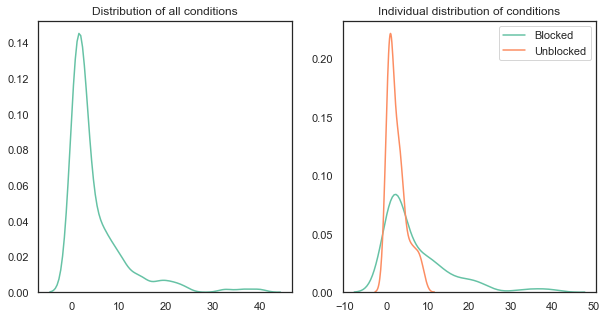

In [28]:
variable="normd soma mean intensity after bg subtract" #change me

x=df[variable].values
normdvar=(x-x.mean())/x.std()
print(type(normdvar))

import scipy.stats as ss
[_,pval]=ss.kstest(normdvar,'norm')
if pval<0.05:
    print("The variable does not distribute normally")
else:
    print("The variable distributes normally")

    sns.set(font_scale=1)
fig=plt.figure(figsize=(10,5))
fig.add_subplot(121)
sns.kdeplot(df[variable],legend=False)
plt.title('Distribution of all conditions')
fig.add_subplot(122)
for condition in list(set(df["exp_condition"])):
    sns.kdeplot(df[df["exp_condition"]==condition][variable],legend=False)
    
    plt.legend(list(set(df["exp_condition"])),loc='upper right')
    plt.title('Individual distribution of conditions')
    

### Plot bg subtracted intensity as a function of time, for each cell - soma

In [29]:
expsblocked={"blockedmean":[],"blockedtimepoint":[],"blockedexpname":[]}
expsunblocked={"unblockedmean":[],"unblockedtimepoint":[],"unblockedexpname":[]}
for exp in df["expname"].unique():
    dfexp=df[df["expname"]==exp]
    if dfexp["exp_condition"].unique()[0]=="Blocked":
        
        
        for time in range(1,9):
            expsblocked["blockedexpname"].append(exp)
            dftime=dfexp[dfexp["timepoint"]==time]
            expsblocked["blockedtimepoint"].append(time)
            print(dftime["normd soma mean intensity after bg subtract"].values.mean())
            expsblocked["blockedmean"].append(dftime["normd soma mean intensity after bg subtract"].values.mean())
    if dfexp["exp_condition"].unique()[0]=="Unblocked":
        
        for time in range(1,9):
            expsunblocked["unblockedexpname"].append(exp)
            dftime=dfexp[dfexp["timepoint"]==time]
            expsunblocked["unblockedtimepoint"].append(time)
            expsunblocked["unblockedmean"].append(dftime["normd soma mean intensity after bg subtract"].values.mean())

True
1.0
1.612406821025069
3.3050831867933335
6.417686209651355
8.494979914296488
9.957436763422486
9.660852433700029
10.799364851242622
True
1.0
1.2587453296492686
3.927739774584996
8.70538567795057
14.544778088341747
18.611448072444894
20.207153545286786
21.02591435272697
True
1.0
5.302287460934404
5.677748387193186
7.545339930106674
8.297380426598242
7.174511740881521
7.688696815218115
6.6284728307281755
True
1.0
1.5288396602091436
4.5960027770724725
7.623172057700544
6.8306634422116455
6.593864215862538
6.6001968538612665
5.9123535365945425
True
1.0
1.625861735891517
2.1784784404890045
2.4581527821585047
2.703365076820523
3.0019345899337115
2.933024718265631
2.5691826601281176


/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: Mean of empty slice.


In [30]:
dfblocked=pd.DataFrame(expsblocked)
dfunblocked=pd.DataFrame(expsunblocked)

In [62]:

dfblocked.loc[dfblocked["blockedtimepoint"]==1,"blockedtimepoint"]=0
dfunblocked.loc[dfunblocked["unblockedtimepoint"]==1,"unblockedtimepoint"]=0




0.04232395190214306


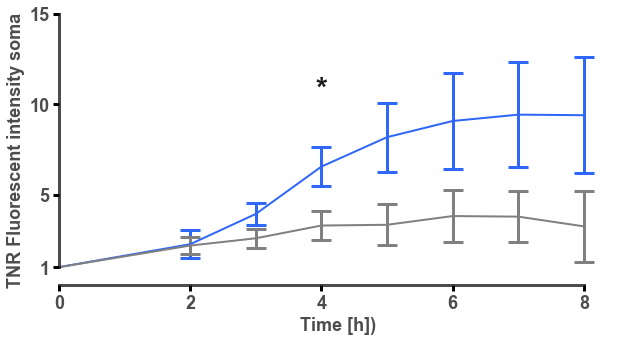

In [68]:
sns.set(font_scale=2.5)
sns.set(font="Arial")
sns.set_style("ticks")
sns.set_palette("Set2")



y_axis="blockedmean"
var="blockedmean"
var2="unblockedmean"


fig=plt.figure(figsize=(10,5))
#g=sns.swarmplot(x="blockedtimepoint", y="blockedmean", data=dfblocked,linewidth=1,color='magenta',size=8,alpha=.7);
g=sns.lineplot(x="blockedtimepoint", y="blockedmean", data=dfblocked,linewidth=2,color="#2F67F8",ci=None);
#g=sns.swarmplot(x="unblockedtimepoint", y="unblockedmean", data=dfunblocked,linewidth=1,color='grey',size=8,alpha=.7);
g=sns.lineplot(x="unblockedtimepoint", y="unblockedmean", data=dfunblocked,linewidth=2,color='grey',ci=None);




g.errorbar(x=[1,2,3,4,5,6,7,8],
             y=[dfblocked[dfblocked["blockedtimepoint"]==1][var].mean(),
                dfblocked[dfblocked["blockedtimepoint"]==2][var].mean(),
                dfblocked[dfblocked["blockedtimepoint"]==3][var].mean(),
                dfblocked[dfblocked["blockedtimepoint"]==4][var].mean(),
                dfblocked[dfblocked["blockedtimepoint"]==5][var].mean(),
                dfblocked[dfblocked["blockedtimepoint"]==6][var].mean(),
                dfblocked[dfblocked["blockedtimepoint"]==7][var].mean(),
                dfblocked[dfblocked["blockedtimepoint"]==8][var].mean()],
             yerr=[dfblocked[dfblocked["blockedtimepoint"]==1][var].sem(),
                dfblocked[dfblocked["blockedtimepoint"]==2][var].sem(),
                dfblocked[dfblocked["blockedtimepoint"]==3][var].sem(),
                dfblocked[dfblocked["blockedtimepoint"]==4][var].sem(),
                dfblocked[dfblocked["blockedtimepoint"]==5][var].sem(),
                dfblocked[dfblocked["blockedtimepoint"]==6][var].sem(),
                dfblocked[dfblocked["blockedtimepoint"]==7][var].sem(),
                dfblocked[dfblocked["blockedtimepoint"]==8][var].sem()],
             xerr=None,ecolor="#2F67F8",fmt='none',capsize=10,linewidth=3,capthick=3)

g.errorbar(x=[1,2,3,4,5,6,7,8],
             y=[dfunblocked[dfunblocked["unblockedtimepoint"]==1][var2].mean(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==2][var2].mean(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==3][var2].mean(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==4][var2].mean(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==5][var2].mean(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==6][var2].mean(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==7][var2].mean(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==8][var2].mean()],
             yerr=[dfunblocked[dfunblocked["unblockedtimepoint"]==1][var2].sem(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==2][var2].sem(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==3][var2].sem(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==4][var2].sem(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==5][var2].sem(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==6][var2].sem(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==7][var2].sem(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==8][var2].sem()],
             xerr=None,ecolor='grey',fmt='none',capsize=10,linewidth=3,capthick=3)

#dftest=df2plot[df2plot["timepoint"]==4]
control=dfunblocked[dfunblocked["unblockedtimepoint"]==4]["unblockedmean"].values
Blocked=dfblocked[dfblocked["blockedtimepoint"]==4]["blockedmean"].values
[stat,pval]=stats.ttest_ind(control, Blocked)
#bonferroni correction, but divide by 2 for directional ttest
#plot
print(pval) 
col='k'
y=10
h=0
x1,x2=3,5
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=24, weight='bold')
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col,size=24, weight='bold')
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size=30, weight='bold')
#else:
 #   plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col,size=10, weight='bold')


plt.title('')
plt.locator_params(axis='y', nbins=5)

#g.vlines(x=4,linestyles='--', label='',ymin=0,ymax=17,color='grey')

g.tick_params(width=3,color='black')
#g.set_ylabel('Fluorescence intensity (AU)',color='black',alpha=.7,labelpad=3,size=28,weight='bold')
g.set_ylabel('TNR Fluorescent intensity soma',color='black',alpha=.7,fontsize=18,weight='bold')
g.set_xlabel('Time [h])',color='black',alpha=.7,fontsize=18,weight='bold')
g.grid(False)

plt.xlim([0,8.5])
plt.ylim([0,15])
plt.yticks([1,5,10,15],visible=True,weight='bold',color='black',alpha=.7,fontsize=18)
plt.xticks([0,2,4,6,8],visible=True,weight='bold',color='black',alpha=.7,fontsize=18)


sns.despine(ax=g,right=True,top=True,trim=True)
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(3)
  g.spines[axis].set_color('black')
  g.spines[axis].set_alpha(.7)


diri="/Volumes/Macintosh HD/Users/taldankovich/Downloads/figures/"

fig.savefig(diri+'endocytosis_nikon.svg', bbox_inches='tight', format='svg')
    

0.04232395190214306


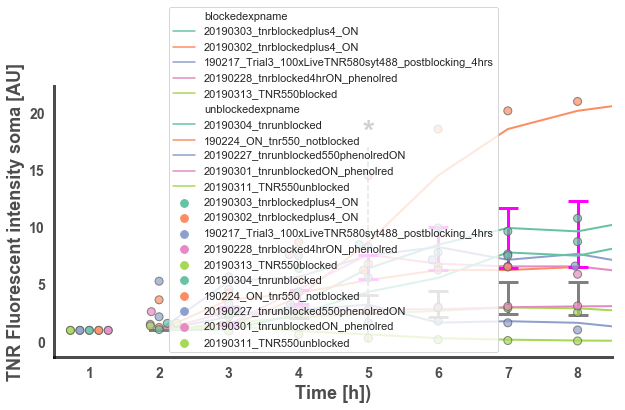

In [14]:
rc('text', usetex=False)


sns.set(font_scale=2.5)
sns.set(font="Arial")
sns.set_style("white")
sns.set_palette("Set2")



y_axis="blockedmean"
var="blockedmean"
var2="unblockedmean"


fig=plt.figure(figsize=(10,5))
g=sns.swarmplot(x="blockedtimepoint", y="blockedmean", data=dfblocked,linewidth=1,hue="blockedexpname",size=8,alpha=.7);
g=sns.lineplot(x="blockedtimepoint", y="blockedmean", data=dfblocked,linewidth=2,hue="blockedexpname",ci=None);
#g=sns.swarmplot(x="unblockedtimepoint", y="unblockedmean", data=dfunblocked,linewidth=1,hue="unblockedexpname",size=8,alpha=.7);
#g=sns.lineplot(x="unblockedtimepoint", y="unblockedmean", data=dfunblocked,linewidth=2,color='grey',ci=None);
g=sns.swarmplot(x="unblockedtimepoint", y="unblockedmean", data=dfunblocked,linewidth=1,hue="unblockedexpname",size=8,alpha=.7);
g=sns.lineplot(x="unblockedtimepoint", y="unblockedmean", data=dfunblocked,linewidth=2,hue="unblockedexpname",ci=None);



g.errorbar(x=[1,2,3,4,5,6,7,8],
             y=[dfblocked[dfblocked["blockedtimepoint"]==1][var].mean(),
                dfblocked[dfblocked["blockedtimepoint"]==2][var].mean(),
                dfblocked[dfblocked["blockedtimepoint"]==3][var].mean(),
                dfblocked[dfblocked["blockedtimepoint"]==4][var].mean(),
                dfblocked[dfblocked["blockedtimepoint"]==5][var].mean(),
                dfblocked[dfblocked["blockedtimepoint"]==6][var].mean(),
                dfblocked[dfblocked["blockedtimepoint"]==7][var].mean(),
                dfblocked[dfblocked["blockedtimepoint"]==8][var].mean()],
             yerr=[dfblocked[dfblocked["blockedtimepoint"]==1][var].sem(),
                dfblocked[dfblocked["blockedtimepoint"]==2][var].sem(),
                dfblocked[dfblocked["blockedtimepoint"]==3][var].sem(),
                dfblocked[dfblocked["blockedtimepoint"]==4][var].sem(),
                dfblocked[dfblocked["blockedtimepoint"]==5][var].sem(),
                dfblocked[dfblocked["blockedtimepoint"]==6][var].sem(),
                dfblocked[dfblocked["blockedtimepoint"]==7][var].sem(),
                dfblocked[dfblocked["blockedtimepoint"]==8][var].sem()],
             xerr=None,ecolor="#2F67F8",fmt='none',capsize=10,linewidth=3,capthick=3)

g.errorbar(x=[1,2,3,4,5,6,7,8],
             y=[dfunblocked[dfunblocked["unblockedtimepoint"]==1][var2].mean(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==2][var2].mean(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==3][var2].mean(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==4][var2].mean(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==5][var2].mean(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==6][var2].mean(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==7][var2].mean(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==8][var2].mean()],
             yerr=[dfunblocked[dfunblocked["unblockedtimepoint"]==1][var2].sem(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==2][var2].sem(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==3][var2].sem(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==4][var2].sem(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==5][var2].sem(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==6][var2].sem(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==7][var2].sem(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==8][var2].sem()],
             xerr=None,ecolor='grey',fmt='none',capsize=10,linewidth=3,capthick=3)

#dftest=df2plot[df2plot["timepoint"]==4]
control=dfunblocked[dfunblocked["unblockedtimepoint"]==4]["unblockedmean"].values
Blocked=dfblocked[dfblocked["blockedtimepoint"]==4]["blockedmean"].values
[stat,pval]=stats.ttest_ind(control, Blocked)
#bonferroni correction, but divide by 2 for directional ttest
#plot
print(pval) 
col='k'
y=17
h=0
x1,x2=3,5
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=24, weight='bold')
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col,size=24, weight='bold')
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size=30, weight='bold')
#else:
 #   plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col,size=10, weight='bold')


plt.title('')
plt.locator_params(axis='y', nbins=5)
plt.yticks(visible=True,weight='bold',color='black',alpha=.7,fontsize=14)
plt.xticks(visible=True,weight='bold',color='black',alpha=.7,fontsize=14)

g.vlines(x=4,linestyles='--', label='',ymin=0,ymax=17,color='grey')

g.tick_params(width=3,color='black')
#g.set_ylabel('Fluorescence intensity (AU)',color='black',alpha=.7,labelpad=3,size=28,weight='bold')
g.set_ylabel('TNR Fluorescent intensity soma [AU]',color='black',alpha=.7,fontsize=18,weight='bold')
g.set_xlabel('Time [h])',color='black',alpha=.7,fontsize=18,weight='bold')
g.grid(False)

sns.despine(ax=g,right=True,top=True)
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(3)
  g.spines[axis].set_color('black')
  g.spines[axis].set_alpha(.7)


    
    

## do the same for neurites

In [16]:
expsblocked={"blockedmean":[],"blockedtimepoint":[],"blockedexpname":[]}
expsunblocked={"unblockedmean":[],"unblockedtimepoint":[],"unblockedexpname":[]}
for exp in df["expname"].unique():
    dfexp=df[df["expname"]==exp]
    if dfexp["exp_condition"].unique()[0]=="Blocked":
        print(True)
        
        for time in range(1,9):
            expsblocked["blockedexpname"].append(exp)
            dftime=dfexp[dfexp["timepoint"]==time]
            expsblocked["blockedtimepoint"].append(time)
            expsblocked["blockedmean"].append(dftime["normd neurite linescan mean intensity after bg subtract"].values.mean())
    if dfexp["exp_condition"].unique()[0]=="Unblocked":
        
        for time in range(1,9):
            expsunblocked["unblockedexpname"].append(exp)
            dftime=dfexp[dfexp["timepoint"]==time]
            expsunblocked["unblockedtimepoint"].append(time)
            expsunblocked["unblockedmean"].append(dftime["normd neurite linescan mean intensity after bg subtract"].values.mean())

True
True
True
True
True


/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice.
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [19]:
dfblocked=pd.DataFrame(expsblocked)
dfunblocked=pd.DataFrame(expsunblocked)

NameError: name 'df2plot' is not defined

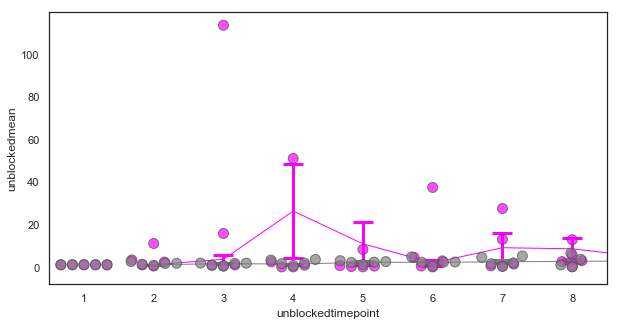

In [20]:
sns.set(font_scale=2.5)
sns.set(font="Arial")
sns.set_style("white")
sns.set_palette("Set2")



y_axis="blockedmean"
var="blockedmean"
var2="unblockedmean"


fig=plt.figure(figsize=(10,5))
g=sns.swarmplot(x="blockedtimepoint", y="blockedmean", data=dfblocked,linewidth=1,color='magenta',size=10,alpha=.7);
g=sns.lineplot(x="blockedtimepoint", y="blockedmean", data=dfblocked,linewidth=1,color='magenta',ci=None);
g=sns.swarmplot(x="unblockedtimepoint", y="unblockedmean", data=dfunblocked,linewidth=1,color='grey',size=10,alpha=.7);
g=sns.lineplot(x="unblockedtimepoint", y="unblockedmean", data=dfunblocked,linewidth=1,color='grey',ci=None);




g.errorbar(x=[1,2,3,4,5,6,7,8],
             y=[dfblocked[dfblocked["blockedtimepoint"]==1][var].mean(),
                dfblocked[dfblocked["blockedtimepoint"]==2][var].mean(),
                dfblocked[dfblocked["blockedtimepoint"]==3][var].mean(),
                dfblocked[dfblocked["blockedtimepoint"]==4][var].mean(),
                dfblocked[dfblocked["blockedtimepoint"]==5][var].mean(),
                dfblocked[dfblocked["blockedtimepoint"]==6][var].mean(),
                dfblocked[dfblocked["blockedtimepoint"]==7][var].mean(),
                dfblocked[dfblocked["blockedtimepoint"]==8][var].mean()],
             yerr=[dfblocked[dfblocked["blockedtimepoint"]==1][var].sem(),
                dfblocked[dfblocked["blockedtimepoint"]==2][var].sem(),
                dfblocked[dfblocked["blockedtimepoint"]==3][var].sem(),
                dfblocked[dfblocked["blockedtimepoint"]==4][var].sem(),
                dfblocked[dfblocked["blockedtimepoint"]==5][var].sem(),
                dfblocked[dfblocked["blockedtimepoint"]==6][var].sem(),
                dfblocked[dfblocked["blockedtimepoint"]==7][var].sem(),
                dfblocked[dfblocked["blockedtimepoint"]==8][var].sem()],
             xerr=None,ecolor='magenta',fmt='none',capsize=10,linewidth=3,capthick=3)

g.errorbar(x=[1,2,3,4,5,6,7,8],
             y=[dfunblocked[dfunblocked["unblockedtimepoint"]==1][var2].mean(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==2][var2].mean(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==3][var2].mean(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==4][var2].mean(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==5][var2].mean(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==6][var2].mean(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==7][var2].mean(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==8][var2].mean()],
             yerr=[dfunblocked[dfunblocked["unblockedtimepoint"]==1][var2].sem(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==2][var2].sem(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==3][var2].sem(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==4][var2].sem(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==5][var2].sem(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==6][var2].sem(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==7][var2].sem(),
                dfunblocked[dfunblocked["unblockedtimepoint"]==8][var2].sem()],
             xerr=None,ecolor='grey',fmt='none',capsize=10,linewidth=3,capthick=3)

dftest=df2plot[df2plot["timepoint"]==4]
control=dfunblocked[dfunblocked["unblockedtimepoint"]==4]["unblockedmean"].values
Blocked=dfblocked[dfblocked["blockedtimepoint"]==4]["blockedmean"].values
[stat,pval]=stats.ttest_ind(control, Blocked)
#bonferroni correction, but divide by 2 for directional ttest
#plot
print(pval) 
col='k'
y=17
h=0
x1,x2=3,5
if pval<0.001:
    plt.text((x1+x2)*.5, y+h, "***", ha='center', va='bottom', color=col,size=24, weight='bold')
elif pval<0.01:
    plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col,size=24, weight='bold')
elif pval<0.05:
    plt.text((x1+x2)*.5, y+h, "*", ha='center', va='bottom', color=col,size=30, weight='bold')
#else:
 #   plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col,size=10, weight='bold')
counter+=1

plt.title('')
plt.locator_params(axis='y', nbins=5)
plt.yticks(visible=True,weight='bold',color='black',alpha=.7,fontsize=14)
plt.xticks(visible=True,weight='bold',color='black',alpha=.7,fontsize=14)

g.vlines(x=4,linestyles='--', label='',ymin=0,ymax=17,color='grey')

g.tick_params(width=3,color='black')
#g.set_ylabel('Fluorescence intensity (AU)',color='black',alpha=.7,labelpad=3,size=28,weight='bold')
g.set_ylabel('TNR Fluorescent intensity soma [AU]',color='black',alpha=.7,fontsize=18,weight='bold')
g.set_xlabel('Time [h])',color='black',alpha=.7,fontsize=18,weight='bold')
g.grid(False)

sns.despine(ax=g,right=True,top=True)
for axis in ['top','bottom','left','right']:
  g.spines[axis].set_linewidth(3)
  g.spines[axis].set_color('black')
  g.spines[axis].set_alpha(.7)